# Exercise 13: A nonlinear version of `mBasicInt`

In this exercise you will get familiar with non-linear energy system models. It is required that you have read the lecture note on non-linear energy system models.

We will be working with a nonlinear version of the rather simple `mBasicInt` model.

We start by importing standard packages:

In [1]:
%run ../stdPackages.ipynb
from pyDbs import read, readSets, broadcast

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


For plotting, we use:

In [2]:
figs_path = os.path.join(d['curr'],'E46','Figs')
%run Exercises/s_PaperPlotting.ipynb
print_pgf()
%matplotlib inline

`mBasicInt_NL` is the class you will be working for in this exercise. 

In [3]:
from py.mBasicInt_NL import *

Finally, we will load in the database for the model. First, we specify the path to the data file:

In [4]:
path_to_data = os.path.join(d['curr'],'E46','Data','E46_Data.xlsx')

We then specify the dictionary, which characterize the structure of the excel file:

In [5]:
kwargs = {'variables': ['Fundamentals', 'Load', 'Generators_Other'],
        'maps': ['Generators_Categories','hMaps'],
        'variable2D': ['HourlyVariation','Generators_FuelMix'],
        'scalars': ['Scalars']}

Now we read in the data:

In [6]:
db = read.dbFromWB(path_to_data, kwargs)
db.updateAlias(alias=[('h','h_alias')])
readSets(db)

The model database, `db`, contains $H=$8760 hours and parameterizes a large-scale model. When developing a model it can be time consuming to check the correctness of the code if the model is large. For simplicity, we will in many cases work with a small-scale model with just $H=2$ hour and we create the small model database by slicing the large database.

Note: While we could randomly choose $H=2$ hours, we will do choose the hours based on 10th and 90th percentiles of the expected price distribution.

In [7]:
# Compute the following variable that - for a given percentile - will have the same hour as for the residual demand curve:
demand = (db['LoadVariation'] * db['Load']).droplevel('c')
wind_cap = (adjMultiIndex.bc(db['GeneratingCapacity'], db['id2hvt']) * db['CapVariation']).dropna().xs('Wind',level='hvt').droplevel('id')
res_d = (demand-wind_cap).astype(float)

# Now get the hours
new_h = pd.Index(np.sort([
    res_d[res_d == res_d.quantile(0.1, interpolation='lower')].index[0],
    res_d[res_d == res_d.quantile(0.9, interpolation='lower')].index[0]
]),name='h').astype(int)

Note that we chosen the following four hours:

In [8]:
new_h.tolist()

[3460, 5266]

Now we subset the large database:

In [9]:
# Now make the small database
db_s = db.copy() # Make a copy of the database

db_s['h'] = new_h.copy() # Add new the index
db_s.updateAlias(alias=[('h','h_alias')]) # Update h_alias

# Now subset variables, which depend on 'h':
for var in db_s.variableDomains(set_='h',types=['variable']).keys():
    db_s[var] = adj.rc_pd(db_s[var],new_h)

# Part 1: Solving the small-scale model

In this part of the exercise, you will be working with the small-scale model for building and solving a non-linear energy system model. Before building the non-linear model, however, let's have a look at the initialization of the class, `mSimpleNL`.

The model initialization then consists of the following code-chunk:
```python
class mSimpleNL(): 
    def __init__(self, db):
        self.db = db.copy()
        mSimpleNL.updateDB(db) # <-- The model database is updated by adding a smoothing parameter (sigma) and a price vector. 
        self.db = db # <-- Assigns the model database to the class.
        self.endo_vars = {'endo_vars':['p'],'theta_vars':[]} # <-- See Comment A)
        self.idx_endo = {'p': range(0,len(self.db['h']))} # <-- See Comment B)
        self.set_model_structure() # <-- This function sets class properties relating to the dimensions of the model.
        self.set_model_parameters()	# <-- This function sets model parameters (i.e. exogenous parameters)
```
Somme additional comments are warranted:

*Comment A):* The keys of this dictionary are the endogenous variables (denoted _endo_vars_) and the endogenous parameters in a structural estimation (denoted _theta_vars_). The values are a list of variable names. For now, we will abstract from any estimation and therefore _theta_vars_ is just an empty list. This dictionary is really helpful, when the vector of endogenous variables consists of multiple variables. 

*Comment B):* _idx_endo_ specifies the index numbers of the endogenous numpy array. For instance: The endogenous price vector is indexed by the first $0:H$ hours.

Finally, let's have a look at the following function in the `mSimpleNL`-class:

```python
def xArray2pdSeries(self,x,variable='p'):
    """ Method for transforming endogenous variables from a numpy array to an indexed Pandas Series """
    if variable in self.endo_vars['endo_var']+self.endo_vars['theta_var']:
        return pd.Series(x[self.idx_endo[variable]],index=self.db[variable].index,name=variable) if (pyDbs.type_(self.db[variable])=='variable') else x[self.idx_endo[variable]] if (pyDbs.type_(self.db[variable])=='scalar') else None
    else:
        return self.db[variable]

```

The _xArray2pdSeries_-function converts the endogenous vector (a numpy array) to a pandas series with the correct index. Rather than being structured via numpy arrays, the model is structured via pandas series. This is less efficient than working with numpy arrays, but when working with (potentially) high-dimensional models the multindex-feature of pandas series greatly simplifies defining the structure of the model. Especially, when defining such models for the first time. 

We now iniatialize the model class:

In [10]:
m = mSimpleNL(db_s)

To test the model we need a guess of the equilibrium price vector $\mathbf{p}^*=(p_1^*,\ldots,p_H^*)'$. We are going to denote it $p^0$ and just assume it is given by the average generation costs:

\begin{equation*}
    \overline{c} \equiv \frac{1}{N}\sum_{i=1}^{N} \overline{c}_i, \qquad \overline{c}_i\equiv \left(c^{\text{other}}_i+\sum_j \mu_{i,j}p_j\right)
\end{equation*}

Note that $\overline{c}_i$ is computed using the `averageMC`-property in the `mSimple`-class. Hence, we can compute $\overline{c}$ as:

In [11]:
p0 = np.repeat(m.averageMC.mean(),m.H)

## E1.1

Consider an economy with a continuum of consumers. Each consumer is indexed by $k$ and the total mass of consumers is 1. By this, we mean that all consumers have a unique $k\in[0,1]$. Consumers are heterogenous with respect to their marginal willingness to pay $(W)$, which is normally distributed with mean $w$ and variance $\left(\sigma^L\right)^2$, i.e.

$$W\sim\mathcal{N}\left(w,\left(\sigma^L\right)^2\right)$$

The marginal willingess to pay is unobserved by the researcher but known to the individual.

Finally, each consumer demands either $D_h>0$ or zero if yhr marginal willinges to pay is larger than or equal to the electricity prices. In other words, the demand function for each consumer $k$ is 

\begin{align}
 L_{h,k} =\begin{cases}
 D_h, & W_k\geq p_h \\
 0, & W_k<p_h
 \end{cases}
\end{align}


__Show that the expected demand function is given by__

$$L_h(p)=D_h\Phi\left(\frac{w-p_h}{\sigma^L}\right)$$

__where $\Phi$ is the cdf of the standard normal distribution.__

_Hint: First derive the expected demand of an individual consumer $k$. Then derive aggregate demand. Finally, you may note that $W=w+\sigma^L Z$, where $Z$ is a standardized variable normally distributed, i.e. $Z\sim\mathcal{N}(0,1)$._

## E1.2

__Fill in the rest in the 'Load'-function below and add the function to the `mSimple_NL` class:__

```python 
    def Load(self,x):
		""" Load/demand function """
		return ... # <-- fill in here.
```

__To ensure the function works, try computing $\mathbf{L}(\mathbf{p}^0)$. It should look something like this:__

| h | Load |
|:--------:|:--------:|
|  3460   |  65.13   |
|  5266   |  97.84   |

_Hint: $\Phi(\cdot)$ can be computed using the [**norm.cdf**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)-function._

## E1.3

__Make a smooth supply function. You should add the following function and fill in the rest in the `mSimpleNL`-class:__
```python
def Supply(self,x):
	""" Smooth supply function """
	Inner = pd.Series(0,index=self.id2h).add(self.xArray2pdSeries(x,variable='p')).sub(self.averageMC).div(self.xArray2pdSeries(x,variable='p'))
	return ... # <-- fill in here.
```
*Note: The function should return the smoothed vector-valued supply function $\mathbf{S}(\mathbf{p})$, which for a given hour is given by*


\begin{equation}
    S_h(p_h) = \sum_i q_i\Phi\left(\frac{p_h-mc_i}{\sigma^E}\right)
\end{equation}

__To ensure the function works, try computing $S(p^0)$. It should look something like this:__

| h | Supply |
|:--------:|:--------:|
|  3460   |  46.63   |
|  5266 |  37.79   |

_Hint: Note that the variable "Inner" in the "Supply"-function above is $\frac{\mathbf{p}-\mathbf{mc}}{\sigma}$._

## E1.4

__Add an excess demand function to `mSimpleNL`. You should copy and fill the rest:__
```python
def ExcessDemand(self,x):
	""" Equilibrium indentity defined as excess demand"""
	return ... # <-- fill in here.
```
*Note: The function should return*

\begin{equation}
\mathbf{ED}(\mathbf{p}) = \mathbf{L}(\mathbf{p})-\mathbf{S}(\mathbf{p})
\end{equation}

__Finally, try computing $\mathbf{ED}(\mathbf{p}^0)$ to ensure the function works. It should something like this:__

| h | Excess Demand |
|:--------:|:--------:|
|  3460  |  18.50   |
|  5266   |  60.04   |

## E1.5

In this question, you are asked to comment on two graphs: The first is the supply and demand curve for each hour. The second if the excess demand function in each hour. 

__Specifically, comment on the equilibrium in each hour.__

We will start out by making a price grid to draw the function of this grid:

In [16]:
grid_size = 100
p_min, p_max = 0, db['meanMWP']*1.4
p_grid = np.linspace(p_min,p_max,grid_size).repeat(m.H).reshape(grid_size,m.H) 

Now we compute the supply over each grid point:

In [17]:
S = pd.Series(
    np.array([m.Supply(x).values for x in p_grid]).flatten(),
    index=pd.MultiIndex.from_product([p_grid.mean(axis=1),m.db['h'].tolist()],names=['p','h']),
    name=r'Supply'
)

We can also compute the merit order curve:

In [18]:
ϵ = np.finfo(float).eps*1e8
S_moc = pd.concat([m.hourlyGeneratingCapacity.rename('q'),adjMultiIndex.bc(m.averageMC,m.db['h']).rename('p')],axis=1)
lo_point = pd.DataFrame(0,index=pd.MultiIndex.from_product([['_lo'],new_h],names=['id','h']),columns=['q','p'])
up_point = np.zeros((len(new_h),2))
up_point[:,0] = ϵ
up_point[:,1] = p_max#+ϵ
up_point = pd.DataFrame(up_point,index=pd.MultiIndex.from_product([['_up'],new_h],names=['id','h']),columns=['q','p'])
S_moc = pd.concat([S_moc,lo_point,up_point],axis=0).sort_values(by=['h','p'])
S_moc['Supply'] = S_moc.groupby('h')['q'].cumsum()
S_moc = S_moc.reset_index().set_index(['p','h'])['Supply']

The perfectly inelastic demand is given by:

In [19]:
# Smooth
D = pd.Series(
    np.array([m.Load(x).values for x in p_grid]).flatten(),
    index=pd.MultiIndex.from_product([p_grid.mean(axis=1),m.db['h'].tolist()],names=['p','h']),
    name=r'Supply'
)
# Non-smooth
D_moc = pd.concat([m.hourlyDemand_c.rename('q'),adjMultiIndex.bc(m.db['meanMWP'],m.hourlyDemand_c.index).rename('p')],axis=1)
D_lo = D_moc.copy()
D_lo.index = pd.MultiIndex.from_product([['_lo'],new_h],names=['c','h'])
D_lo['p'] = 0
D_lo['q'] = D_lo['q']+ϵ
D_up = D_moc.copy()
D_up.index =pd.MultiIndex.from_product([['_up'],new_h],names=['c','h'])
D_up['p'] = D_up['p']+ϵ
D_up['q'] = ϵ
D_up2 = D_moc.copy()
D_up2.index =pd.MultiIndex.from_product([['_up'],new_h],names=['c','h'])
D_up2['p'] = p_max
D_up2['q'] = 0
D_moc = pd.concat([D_moc,D_lo,D_up,D_up2],axis=0).sort_values(by=['h','p'],ascending=True)
# D_moc['Demand'] = D_moc.groupby('h')['q'].cumsum()
D_moc = D_moc.reset_index().set_index(['p','h'])['q']

Now we plot the supply and demand curves:

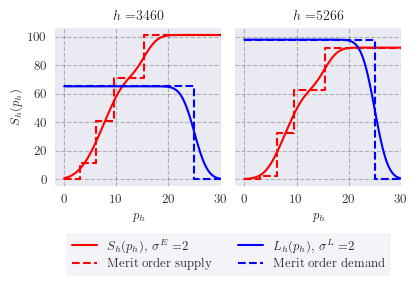

In [20]:
two_graphs()
fig, ax = plt.subplots(ncols=2,sharex=True,sharey=True)
titles = [r'$h=$'+str(x) for x in m.db['h']]
S.unstack('h').plot(subplots=True,ax=ax,color='red',title=titles,xlabel=r'$p_h$',ylabel=r'$S_h(p_h)$',legend=False)
S_moc.unstack('h').plot(drawstyle="steps-post",subplots=True,ax=ax,color='red',linestyle='--',legend=False)
D.unstack('h').plot(subplots=True,ax=ax,color='blue',legend=False)
D_moc.unstack('h').plot(subplots=True,ax=ax,color='blue',linestyle='--',legend=False)
[ax[i].set_xlim(right=db['meanMWP']+5) for i in range(2)];
[ax[i].set_xlabel(r'$p_h$') for i in range(2)];
fig.legend([r'$S_h(p_h)$'+', '+r'$\sigma^E=$'+str(m.db['sigma_E']),'Merit order supply',r'$L_h(p_h)$'+', '+r'$\sigma^L=$'+str(m.db['sigma_L']),'Merit order demand'],loc='lower center', bbox_to_anchor=(0.55, -0.25), ncol=2, frameon=True)
fig.savefig(f"{figs_path}\\Smooth_equilibrium.pgf", edgecolor='k',bbox_inches='tight')

Now we plot the excess demand functions:

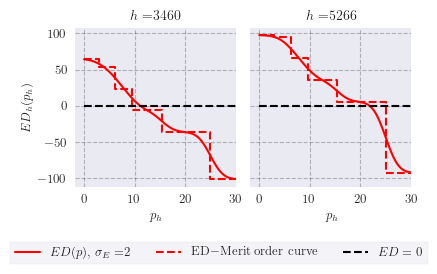

In [21]:
two_graphs()
fig, ax = plt.subplots(ncols=2,sharex=True,sharey=True)
titles = [r'$h=$'+str(x) for x in m.db['h']]
(D-S).unstack('h').plot(subplots=True,ax=ax,color='red',title=titles,ylabel=r'$ED_h(p_h)$',label='ED',legend=False)
x = pd.concat([D_moc.rename('Demand'),S_moc],axis=1).sort_index(level=['h','p']).groupby('h').ffill()
(x['Demand']-x['Supply']).unstack('h').plot(drawstyle="steps-post",subplots=True,ax=ax,color='red',linestyle='--',legend=False)
(D*0).unstack('h').plot(subplots=True,ax=ax,color='black',linestyle='--',legend=False)
[ax[i].set_xlim(right=db['meanMWP']+5) for i in range(2)];
[ax[i].set_xlabel(r'$p_h$') for i in range(2)];
fig.legend([r'$ED(p)$'+', '+r'$\sigma_E=$'+str(m.db['sigma_E']),'ED$-$Merit order curve',r'$ED=0$'],loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3, frameon=True)

## E1.6

You will soon be asked to compute the equilibrium price vector. To do this, we will start by doing this by writing a wrapper around `SCIPY`'s [fsolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html)-function. The fsolve function just compute the solution to a sqaure system of nonlinear equations. 

You should add the following function to `mBasicInt` and fill in the "func"-argument in the _fsolve_-function:

```python
	def ScipySolver(self,p0=None,maxiter=0):
		""" A wrapper around Scipy's fsolve function"""
		if p0 is None:
			p0 = self.db['p'].values # <-- If the user does not provide an initial quess for p*, we will manually assign one.
		sol = fsolve(func=lambda x: ..., x0=p0,full_output=True,maxfev=maxiter) # <-- fill in the dots
		print(sol[-1])
		if sol[-1]=='The solution converged.':
			p_star = sol[0]
			self.unloadSolutionToDB(p_star)
```
*Note: The function your are asked to provide is the equilibrium identity. The easiest approach is to provide a lambda-expression).*

__Finally, run the function using p0 as the initial guess. You should get something like this:__

| h | Excess Demand |
|:--------:|:--------:|
|  3460  |  11.17   |
|  5266   |  21.84   |

# Part 2: Estimating a slightly larger but still small-scale model

In this part of the exercise, we will be estimating a slightly larger non-linear model. Specifically, we will do a structural estimation by fitting the predicted prices of the model with actual prices. The class `mEstimateNL` defines the structural estimation:

```python

class mEstimateNL(mSimpleNL):
	""" A class for estimating a non-linear energy system model"""
	def __init__(self, db):
		super().__init__(db)
		self.theta_vars = ['sigma_E','OtherMC']
		self.endo_vars = {
			'endo_var':['p'],
			'theta_var':self.theta_vars.copy()
		}
		self.idx_endo = {
			'p': range(0,len(self.db['h'])),
			'sigma_E':len(self.db['h']),
			'OtherMC': range(len(self.db['h']) + 1 , len(self.db['h']) + len(self.db['OtherMC']) + 1)
		}
```

In doing so, we will estimate the other operating and maintenance costs $(c_{i}^{\text{other}})$ and the smoothing parameter $\sigma^E$. Since $c_i^{\text{other}}$ affects $c_i$ and $\sigma^E$ affects the supply, we have to update these two. We have therefore added the two following functions to the class:


```python
    def averageMC(self,x):
		""" average marginal generation costs"""
		return self.xArray2pdSeries(x,variable='OtherMC').add((pyDbs.pdSum((self.xArray2pdSeries(x,variable='FuelMix') * self.fuelCost).dropna(), 'BFt')),fill_value=0).astype(float)	

	def Supply(self,x):
		""" Smooth supply function """
		Inner = pd.Series(0,index=self.id2h).add(self.xArray2pdSeries(x,variable='p')).sub(self.averageMC(x)).div(self.xArray2pdSeries(x,variable='sigma_E'))
		return (self.hourlyGeneratingCapacity * Inner.apply(norm.cdf)).groupby('h').sum()
```

We consider the following Maximum Likelihood estimation

\begin{align}
    \max_{\mathbf{\theta}} \log L(\mathbf{\theta})  &\propto \sum_h \ln\left(\phi\left( p_h-\hat{p}_h \right)\right) \\
    &\text{s.t.} \\
    \mathbf{ED}(\mathbf{p}) &=0
\end{align}

where $p_h$ is data, $\hat{p}_h$ is the model-simulated prices, and $\phi$ is the pdf of the normal distribution. Note that $\log L(\mathbf{\theta}))$ is computed in the following function in the `mEstimateNL`-class:

```python
def logLikelihood(self,x,data):
    """ log-likehood objective function in estimation algorithm"""
    return np.log(norm.pdf(data-x[self.idx_endo['p']])).sum()
```

Finally, we implement the constrained Maximum Likelihood estimation using Scipy's [__minimize__](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)-function:

```python
def ConstrainedMLE(self,data,theta0=None,p0=None,maxiter=100,constraints=None):
		"""Estimation algorithm formulated as a constrained Maximum Likelihood Estimation (MLE)"""
		# Initial guess of parameter vector
		if theta0 is None:
			theta0 = np.concatenate([self.db[var].values.astype(float) if pyDbs.type_(self.db[var])=='variable' else np.array([float(self.db[var])]) if pyDbs.type_(self.db[var])=='scalar' else None for var in self.endo_vars['theta_var']]).ravel().astype(float)
		# Initial guess of price vector
		if p0 is None:
			p0 = self.db['p'].values
		x0 = np.append(p0,theta0)
		# Solution
		sol = minimize(
			fun = lambda x: self.logLikelihood(x,data=data),
			x0 = x0,
			constraints = [{'type':'eq','fun':self.ExcessDemand}],
			options = {'maxiter':maxiter}
		)
		print(sol['message'])
		if sol['success']:
			self.x = sol['x']
			self.theta_hat = sol['x'][range(len(self.db['h']),max(self.idx_endo[self.endo_vars['theta_var'][-1]])+1)]
			self.unloadSolutionToDB(self.x)
```

We start by downloading data for Danish prices in 2022:

In [25]:
data_dir = os.path.abspath(os.path.join(os.getcwd(),'DownloadDataForDK','CleanedData','SpotPrices_DELUDK1DK2NLNO2SE3SE4_2022'))
data_raw = pd.read_pickle(data_dir)

In stead of fitting prices for the entire year, we just fit a representative week:

In [26]:
data = data_raw[data_raw['g_E'].str.find('DK')!=-1].copy()
g_cols = ['Week','HourOfTheDay','h']
data['h2'] = data.groupby(['HourOfTheDay']).grouper.group_info[0]+1
h_map = data[['h','h2']].drop_duplicates().reset_index(drop=True).sort_values(by='h').set_index('h')['h2']
data = data.groupby('h2')['SpotPrice_€/MWh'].mean().div(3.6).rename('p_data').rename_axis('h')

Now we need to slice and aggregate the large database accordingly:

In [27]:
# Now make the small database
db_est = db.copy() # Make a copy of the database

# Now subset variables, which depend on 'h':
for var in db_est.variableDomains(set_='h',types=['variable']).keys(): 
    x = db_est[var].rename(h_map.to_dict(),level='h',axis=0)
    db_est[var] = x.groupby(x.index.names).sum()
    
db_est['h'] = pd.Index(h_map.sort_values().unique(),name='h') # Add new the index
db_est.updateAlias(alias=[('h','h_alias')]) # Update h_alias

# Updating maximum MWP
db_est['meanMWP'] = 100

Finally, for finding good starting values, we will be the solution from the standard LP framework in the `mBasicInt` class. 

In [28]:
# Importing packages:
os.chdir(d['py'])
from mBasicInt import *
os.chdir(d['curr'])

# Renaming MWP:
db_est['MWP'] = db_est['meanMWP']

# Initializing, solving, and extracting prices:
m_LP = mSimple(db_est)
m_LP()
p0 = m_LP.db['marginalSystemCosts']

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


Now we initialize the non-linear class on the larger model database:

In [29]:
m_est = mEstimateNL(db_est)

And then we first compute equilibrium price vector:

In [30]:
endo_vars = m_est.endo_vars.copy()
m_est.endo_vars = {'endo_var':['p'],'theta_var': []}
m_est.ScipySolver(p0=p0.values)
p_star = m_est.db['p'].copy()

The solution converged.


We can now estimate the model by running:

In [31]:
m_est.endo_vars = endo_vars
m_est.ConstrainedMLE(p0=p_star.values,data=data.values,maxiter=1000)

Optimization terminated successfully


The estimated parameters are:

In [30]:
mi = pd.MultiIndex.from_arrays([
    [r'$\sigma^E$',r'$c^{\text{other}}$',r'$c^{\text{other}}$',r'$c^{\text{other}}$',r'$c^{\text{other}}$'],
    ['','id1','id2','id3','id4']
])
pd.Series(m_est.theta_hat,index=mi).rename(r'$\theta$').to_frame()

$\theta$
$\sigma^E$               2.362117
$c^{\text{other}}$ id1   1.167076
                   id2  38.520903
                   id3  48.897367
                   id4   3.419501

Let's consider the estimated prices:

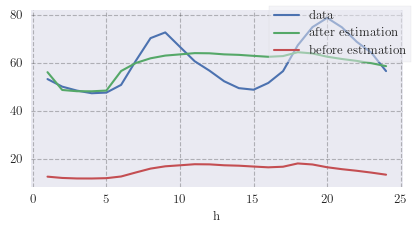

In [31]:
fig, ax = plt.subplots()
data.plot(ax=ax,label='data')
m_est.db['p'].plot(ax=ax,label='after estimation')
p_star.plot(ax=ax,label='before estimation')
fig.legend()

__Why can the current model not replicate the price dip during the middle of the day, even though we can flexibly change the variable costs of generation?__